In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from glob import glob
import pandas as pd
import pickle
import random
from PIL import Image
from glob import glob
import re
#from adjustText import adjust_text
import seaborn as sns
import statannot
import argparse
#import torch
import wandb
import sys
sys.path.append('./modified_medsam_repo')

In [11]:
def read_tag_from_wandb(tag, project_name, min_epoch_cutoff = 4):
    # read yolov7 runs
    api = wandb.Api()
    
    # Project is specified by <entity/project-name>
    runs = api.runs(path =f"nair-karthik00/{project_name}", filters = {'tags': tag})
    #runs.append(api.run('nair-karthik00/MedSAM_finetune_hcp_ya_second_round_with_bbox/a935xpc7'))

    summary_list, config_list, name_list = [], [], []
    id_seen = {}
    for run in runs:
        name = run.name
        #if not re.match(pattern, name):
        #    continue
        if run.id in id_seen.keys(): # sometimes wandb passes in the same run twice, so safeguard against this
            continue
        else:
            id_seen[run.id] = True
        
        
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        dicto = run.summary._json_dict
        #print(dicto)
        if ('val_dice_score' not in dicto.keys() and 'val_dice_scores/class_Unknown' not in dicto.keys()) or dicto['epoch'] < min_epoch_cutoff: # this run is not finished yet
            print('skip ' + name.split('_')[0].split('label')[1])
            continue
        summary_list.append(dicto)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)


    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    desire_cols = ['label', 'val_dice_score']
    runs_df['label'] = [int(x.split('_')[0].split('label')[1]) for x in runs_df['name']]
    if 'val_dice_score' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_score'] for x in runs_df['summary']]
    elif 'val_dice_scores/class_Unknown' in runs_df['summary'][0]:
        runs_df['val_dice_score'] = [x['val_dice_scores/class_Unknown']['max'] for x in runs_df['summary']]
    if 'num_training_samples' in runs_df['summary'][0]:
        runs_df['num_samples_per_epoch'] = [x['num_training_samples'] / (x['epoch']+1) for x in runs_df['summary']]
        runs_df['num_samples_per_epoch'] = runs_df['num_samples_per_epoch'].astype(int)
        desire_cols.append('num_samples_per_epoch')
    
    runs_df['runtime'] = [x['_runtime'] for x in runs_df['summary']]
    desire_cols.append('runtime')

    runs_df = runs_df.sort_values('label').reset_index(drop=True)
    ret_df = runs_df[desire_cols]

    #assert ret_df.shape[0] == 102
    assert ret_df['label'].value_counts().max() == 1
    
    return ret_df

In [ ]:
dfo = read_tag_from_wandb('unet_final_main_run', 'singletask_unet', min_epoch_cutoff = 9)
dfo['model_type'] = 'UNet'

dfo2 = read_tag_from_wandb('medsam_final_diceloss', 'singletask_medsam_no_yolo', min_epoch_cutoff = 9)
dfo2 = dfo2[['label', 'val_dice_score', 'runtime']]
dfo2['model_type'] = 'MedSAM'

dfo3 = read_tag_from_wandb('final_run', 'singletask_medsam_with_yolo', min_epoch_cutoff = 9)
dfo3 = dfo3[['label', 'val_dice_score', 'runtime']]
dfo3['model_type'] = 'MedSAM + YOLO'

combined_df = pd.concat([dfo, dfo2, dfo3], axis=0, ignore_index=True)
combined_df = combined_df.sort_values(['model_type', 'label']).reset_index(drop=True)

combined_df.to_csv('/gpfs/data/luilab/karthik/pediatric_seg_proj/results_copied_from_kn2347/main_training_runtimes_12-17-24/training_runtimes.csv', index=False)

In [16]:
combined_df[100:120]

,label,val_dice_score,runtime,model_type
100,101,0.647358,4984.041026,MedSAM
101,102,0.742135,8266.564876,MedSAM
102,1,0.886768,14817.800648,MedSAM + YOLO
103,2,0.869648,3916.427971,MedSAM + YOLO
104,4,0.731803,5466.600914,MedSAM + YOLO
105,5,0.879079,8673.086674,MedSAM + YOLO
106,6,0.872683,2409.245196,MedSAM + YOLO
107,7,0.877647,3206.574337,MedSAM + YOLO
108,8,0.854013,3644.233057,MedSAM + YOLO
109,9,0.710452,1171.433670,MedSAM + YOLO


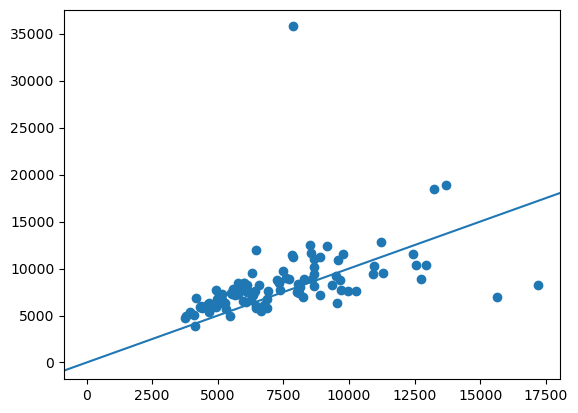

In [28]:
fig, axs = plt.subplots()
axs.scatter(dfo2['runtime'], dfo['runtime'])
axs.axline((0, 0), slope=1)

In [29]:
print('1: mean time is', dfo['runtime'].mean(), 'seconds')
print('1: total time is', dfo['runtime'].mean() * 102, 'seconds')

print('2: mean time is', dfo2['runtime'].mean(), 'seconds')
print('2: total time is', dfo2['runtime'].mean() * 102, 'seconds')

1: mean time is 8393.81137964071 seconds
1: total time is 856168.7607233524 seconds
2: mean time is 7434.276131985234 seconds
2: total time is 758296.1654624939 seconds


In [38]:
dfo['num_samples_per_epoch']

0     96532
1     24944
2      6346
3     36553
4     52707
      ...  
93    48913
94    48092
95    37394
96    13605
97    39100
Name: num_samples_per_epoch, Length: 98, dtype: int64

In [39]:
dfo2['num_samples_per_epoch'].sum() * 2 # have to multiply by 2 because the calculation used epochs=30...60 not 0...30

2827072

In [34]:
3085184 * 30

92555520